## Part I: Preprocessing and EDA

- The data comes from a global e-retailer company, including orders from 2012 to 2015. Import the **Orders** dataset and do some basic EDA. 
- For problem 1 to 3, we mainly focus on data cleaning and data visualizations. You can use all the packages that you are familiar with to conduct some plots and also provide **brief interpretations** about your findings.

### Problem 1: Dataset Import & Cleaning
Check **"Profit"** and **"Sales"** in the dataset, convert these two columns to numeric type. 

In [2]:
import pandas as pd
orders = pd.read_csv('../data/Orders.csv', index_col=0, parse_dates=True)

In [3]:
orders['Profit'] = pd.to_numeric(orders['Profit'].str.replace('$', '').str.replace(',',''))
orders['Sales'] = pd.to_numeric(orders['Sales'].str.replace('$', '').str.replace(',',''))

### Problem 2: Inventory Management
- Retailers that depend on seasonal shoppers have a particularly challenging job when it comes to inventory management. Your manager is making plans for next year's inventory.
- He wants you to answer the following questions:
    1. Is there any seasonal trend of inventory in the company?
    2. Is the seasonal trend the same for different categories?

- ***Hint:*** For each order, it has an attribute called `Quantity` that indicates the number of product in the order. If an order contains more than one product, there will be multiple observations of the same order.

In [4]:
orders['Order.Date'] = pd.to_datetime(orders['Order.Date'])
orders = orders.set_index(orders['Order.Date'])

bins = [0, 91, 183, 275, 366]
labels=['Winter', 'Spring', 'Summer', 'Fall']
doy = orders.index.dayofyear
orders['Season'] = pd.cut(doy + 11 - 366*(doy > 355), bins=bins, labels=labels)

season_trend = orders.groupby(['Season','Category']).agg({'Quantity':['sum']})
season_trend = season_trend.reset_index()
season_trend.columns = ['Season','Category','Quantity']

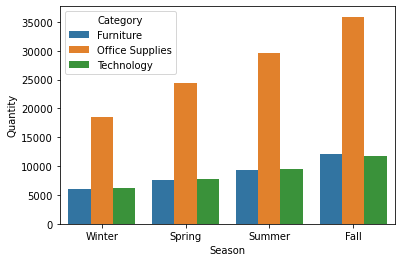

In [5]:
# two lines....
import seaborn as sns
sns.barplot(x="Season", y="Quantity", hue="Category", data=season_trend)

### Problem 3: Why did customers make returns?
- Your manager required you to give a brief report (**Plots + Interpretations**) on returned orders.

	1. How much profit did we lose due to returns each year?


	2. How many customer returned more than once? more than 5 times?


	3. Which regions are more likely to return orders?


	4. Which categories (sub-categories) of products are more likely to be returned?

- ***Hint:*** Merge the **Returns** dataframe with the **Orders** dataframe using `Order.ID`.

In [6]:
returns = pd.read_csv('../data/Returns.csv', index_col=0)
returns.columns = ['Order.ID', 'Region'] # rename columns of returns
returned_orders = orders.merge(returns, left_on='Order.ID', right_on='Order.ID') # merge orders and returns
returned_orders['Year'] = pd.DatetimeIndex(returned_orders['Order.Date']).year # new feature: Year

In [9]:
#Now lets compare how much was lost 
#Filter only products that had a loss
Profit_loss = returned_orders[['Year', 'Profit']]

Profit_loss['Profit'] = Profit_loss[Profit_loss['Profit'] < 0]['Profit']
Profit_loss.dropna()

Profit_Loss_table = Profit_loss.groupby(['Year']).agg({"Profit":['sum']})
Profit_Loss_table

<ipython-input-9-5b5621132392>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Profit_loss['Profit'] = Profit_loss[Profit_loss['Profit'] < 0]['Profit']


,Profit
,sum
Year,
2012,-5772.54
2013,-7713.03
2014,-7439.43
2015,-15907.60


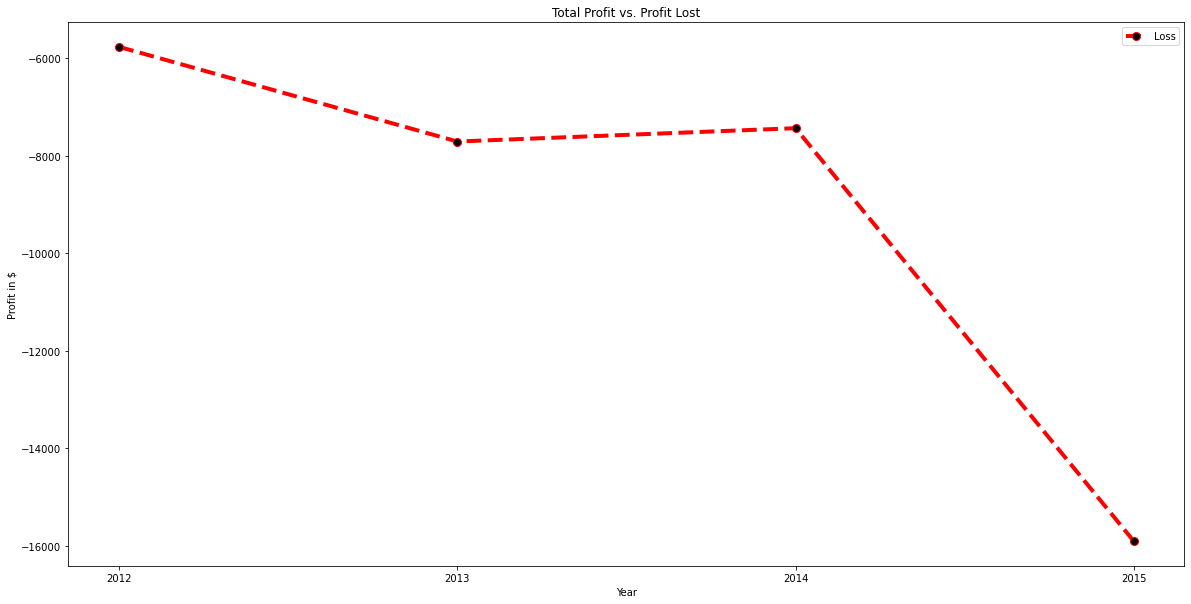

In [10]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
x = [2012, 2013, 2014, 2015]
plt.figure(figsize=(20,10))
# multiple line plot
plt.plot( x, 'Profit', data=Profit_Loss_table, marker='o', markerfacecolor='black', markersize=8, color='red', linewidth=4, linestyle = 'dashed', label = "Loss")
# plt.plot( x, 'Profit', data=Total_Profit, marker='s', markerfacecolor='black', markersize=8, color='blue', linewidth=4, linestyle = 'dashed', label = "Total Profit")
plt.xticks(x)
plt.xlabel('Year')
plt.ylabel('Profit in $') 
plt.title('Total Profit vs. Profit Lost')
plt.legend()

In [11]:
# 2. How many customer returned more than once? more than 5 times?
returned_orders_customer = returned_orders.groupby(['Customer.ID','Order.ID']).agg({"Order.ID":['count']})
returned_orders_customer = returned_orders_customer.reset_index()
print('Number of customers that returned more than once: ',returned_orders_customer[returned_orders_customer['Order.ID']['count']>1]['Customer.ID'].size)
print('Number of customers that returned more than 5 times: ',returned_orders_customer[returned_orders_customer['Order.ID']['count']>5]['Customer.ID'].size)

Number of customers that returned more than once:  551
Number of customers that returned more than 5 times:  41


In [12]:
# 3. Which regions are more likely to return orders?
returned_orders_regions = pd.DataFrame(returns.groupby(['Region']).size())
returned_orders_regions = (returned_orders_regions / returned_orders_regions[0].sum() * 100).round(2).sort_values([0], ascending=False)
returned_orders_regions.reset_index(inplace=True)
returned_orders_regions.columns = ['Region','Percentage']

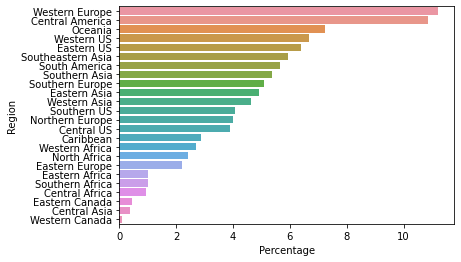

In [13]:
sns.barplot(x="Percentage", y="Region", data=returned_orders_regions, )

In [14]:
# 4. Which categories (sub-categories) of products are more likely to be returned?
returned_categories = pd.DataFrame(returned_orders.groupby(['Category','Sub.Category']).size())
returned_categories = (returned_categories / returned_categories[0].sum() * 100).round(2).sort_values([0], ascending=False)
returned_categories.reset_index(inplace=True)
returned_categories.columns = ['Category', 'Sub.Category', 'Percentage']

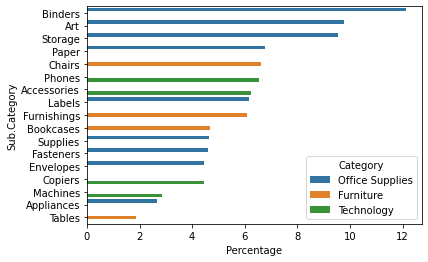

In [15]:
sns.barplot(x="Percentage", y="Sub.Category", hue="Category", data=returned_categories)

## Part II: Machine Learning and Business Use Case

Now your manager has a basic understanding of why customers returned orders. Next, he wants you to use machine learning to predict which orders are most likely to be returned. In this part, you will generate several features based on our previous findings and your manager's requirements.

### Problem 4: Feature Engineering
#### Step 1: Create the dependent variable
- First of all, we need to generate a categorical variable which indicates whether an order has been returned or not.
- ***Hint:*** the returned orders’ IDs are contained in the dataset “returns”


In [16]:
orders1 = pd.read_csv('../data/Orders.csv')
returns1 = pd.read_csv('../data/Returns.csv')
returns1.columns = ['Returns', 'Order.ID', 'Region']

In [17]:
new_orders = pd.merge(orders1, returns1, left_on='Order.ID', right_on='Order.ID', how='outer')
new_orders['Returns']=new_orders['Returns'].fillna('No')


#### Step 2:
- Your manager believes that **how long it took the order to ship** would affect whether the customer would return it or not. 
- He wants you to generate a feature which can measure how long it takes the company to process each order.
- ***Hint:*** Process.Time = Ship.Date - Order.Date


In [18]:
new_orders['Ship.Date']= pd.to_datetime(new_orders['Ship.Date'])
new_orders['Order.Date']= pd.to_datetime(new_orders['Order.Date'])
new_orders['Process.Time'] = new_orders['Ship.Date'].sub(new_orders['Order.Date'], axis=0)

#### Step 3:

- If a product has been returned before, it may be returned again. 
- Let us generate a feature that indicates how many times the product has been returned before.
- If it never got returned, we just impute using 0.
- ***Hint:*** Group by different Product.ID


In [19]:
# change settings to allow all the columns to be displayed
pd.set_option('display.max_columns', None)

In [20]:
# Temp table -> holds number counts of products returned
temp = pd.DataFrame(new_orders[new_orders['Returns']=='Yes'].groupby('Product.ID').size())

In [21]:
# Merge with temp table
new_orders = new_orders.merge(temp, on="Product.ID", how="outer" )

In [22]:
# Replace NaN with zero
new_orders[0].fillna(0, inplace=True)

In [23]:
# Change type of new column to Integer
new_orders[0] = new_orders[0].astype('int64')

In [24]:
# rename column "0" to "Times.Returned"
new_orders.rename(columns={0: "Times.Returned"}, inplace=True)


### Problem 5: Fitting Models

- You can use any binary classification method you have learned so far.
- Use 80/20 training and test splits to build your model. 
- Double check the column types before you fit the model.
- Only include useful features. i.e all the `ID`s should be excluded from your training set.
- Note that there are only less than 5% of the orders have been returned, so you should consider using the [createDataPartition](https://www.rdocumentation.org/packages/caret/versions/6.0-80/topics/createDataPartition) function from `caret` package and [StratifiedKfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn-model-selection-stratifiedkfold) from sklearn when running cross-validation.
- Do forget to `set.seed()` before the spilt to make your result reproducible.
- **Note:** We are not looking for the best tuned model in the lab so don't spend too much time on grid search. Focus on model evaluation and the business use case of each model.


In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [26]:
# Target Variable: replace Yes -> 1 and No -> 0
new_orders.Returns.replace({'Yes':1, 'No':0}, inplace=True)

In [27]:
# Create training set and test set
np.random.seed(0)
testIdxes = np.random.choice(range(new_orders.shape[0]), size= int(new_orders.shape[0] * .2), replace=False)
trainIdxes = list(set(range(new_orders.shape[0]))-set(testIdxes))
train_set = new_orders.iloc[trainIdxes]
test_set = new_orders.iloc[testIdxes]

In [28]:
train_set_encoded = pd.get_dummies(train_set[["Segment",'Sub.Category', 'Returns','Times.Returned']])
test_set_encoded = pd.get_dummies(test_set[["Segment",'Sub.Category', 'Returns', 'Times.Returned']])

In [29]:
y = train_set_encoded.Returns
X = train_set_encoded[train_set_encoded.columns[1:]]
y_test = test_set_encoded.Returns
X_test = test_set_encoded[test_set_encoded.columns[1:]]

In [30]:
# Logistic Regression
logistic = LogisticRegression(C=1e4, solver='lbfgs', multi_class='auto', class_weight="balanced")
logistic.fit(X,y)
print(logistic.score(X, y))
print(logistic.score(X_test, y_test))


0.711420354844999
0.7140768180931956


In [31]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
cclf = RandomForestClassifier(max_depth=21, random_state=0, class_weight="balanced")
cclf.fit(X, y)
print(cclf.score(X,y))
print(cclf.score(X_test,y_test))

0.5793283291089881
0.5742834860596607


### Problem 6: Evaluating Models
- What is the best metric to evaluate your model. Is accuracy good for this case?
- Now you have multiple models, which one would you pick? 
- Can you get any clue from the confusion matrix? What is the meaning of precision and recall in this case? Which one do you care the most? How will your model help the manager make decisions?
- **Note:** The last question is open-ended. Your answer could be completely different depending on your understanding of this business problem.

In [32]:
# AIC or BIC (best for descriptive models)
# ...
# confusion matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y, logistic.predict(X)))  # Logistic Regression
print( (28093+1098) / (28093+11189+652+1098) )
print(confusion_matrix(y, cclf.predict(X)))      # Random Forest
print( (22216+1555) / (22216+17066+195+1555) )
# initially the score was very high but that is because the training data was not balanced.
# Added the option 'balanced' to the LogisticRegression and that brought down the score to a more reasonable number.

[[28093 11189]
 [  652  1098]]
0.711420354844999
[[22216 17066]
 [  195  1555]]
0.5793283291089881


### Problem 7: Feature Engineering Revisit
- Is there anything wrong with the new feature we generated? How should we fix it?
- ***Hint***: For the real test set, we do not know it will get returned or not.

In [ ]:
# ...